# Assessing Model Results

This notebook serves as a demo for an initial assessment of Mike's Calfornia Current regional model. You can follow and/or adapt this notebook based on your configuration if you are using a regional domain.

First, import packages to re-create and visualize the model fields here:

In [27]:
import os
import imageio_ffmpeg

# Force MoviePy / imageio to use the bundled ffmpeg
os.environ["IMAGEIO_FFMPEG_EXE"] = imageio_ffmpeg.get_ffmpeg_exe()
print("Using ffmpeg at:", os.environ["IMAGEIO_FFMPEG_EXE"])


Using ffmpeg at: /opt/anaconda3/envs/ms274_video/lib/python3.11/site-packages/imageio_ffmpeg/binaries/ffmpeg-macos-x86_64-v7.1


In [28]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Rectangle
import moviepy.video.io.ImageSequenceClip


Next, define the location of the run directory for the model. This is the directory that holds all of the output from the model.

In [30]:
# define the input directory
run_dir = '/Users/masonjones/Desktop/MS274/model/run1/diags'

Then, re-create the model grid

In [31]:
delX = 547/8000000
delY = 225291667/1000000000000
xgOrigin = -121.79820967558051
ygOrigin = 36.774869659553836
n_rows = 240
n_cols = 240

# recreate the grids that will be used in the model
xc = np.arange(xgOrigin+delX/2, xgOrigin+n_cols*delX, delX)
yc = np.arange(ygOrigin+delY/2, ygOrigin+n_rows*delY, delY)
XC, YC = np.meshgrid(xc, yc)

## Plot a model field at one timestep
A good first assessment of a model is to plot some of the output fields. Here, I'll choose one of the surface temperature fields. I'll first read in the field, and then I'll plot it

In [32]:
grid = np.fromfile(os.path.join(run_dir,'vel_3D_mon_snap',
                                'vel_3D_mon_snap.0000000900.data'), '>f4')
grid = grid.reshape((2,140,n_rows,n_cols))

U = grid[0]  # UVEL
V = grid[1] #VVEL

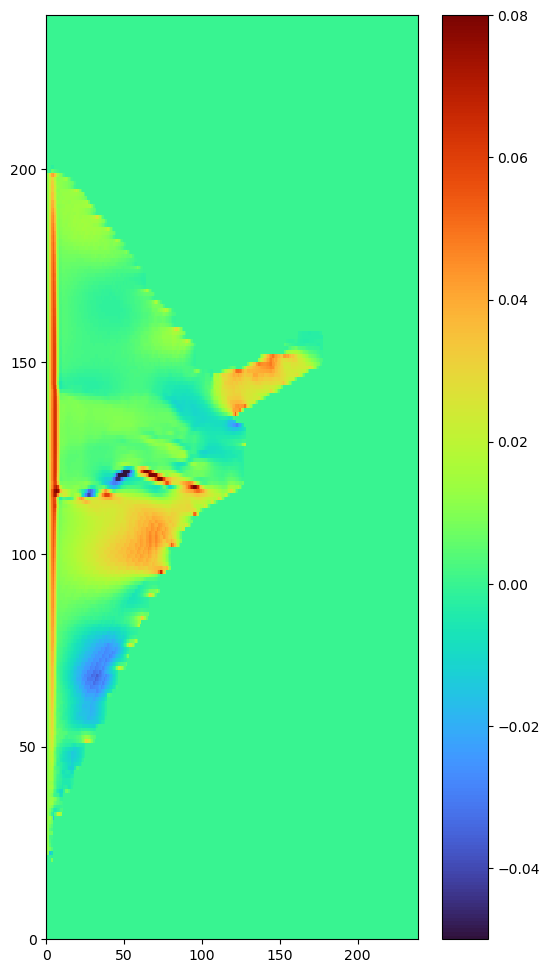

In [33]:
plt.figure(figsize=(6, 12))
C = plt.pcolormesh(grid[0,0,:,:-1], cmap='turbo', vmin=-0.05,vmax=0.08)
plt.colorbar(C)
plt.show()

## Make a timeseries
After plotting a few fields, next we can see how the model is evolving through time. For this example, I'll choose a point in the domain near the coast and I'll plot that on a map to ensure it's in the right location:

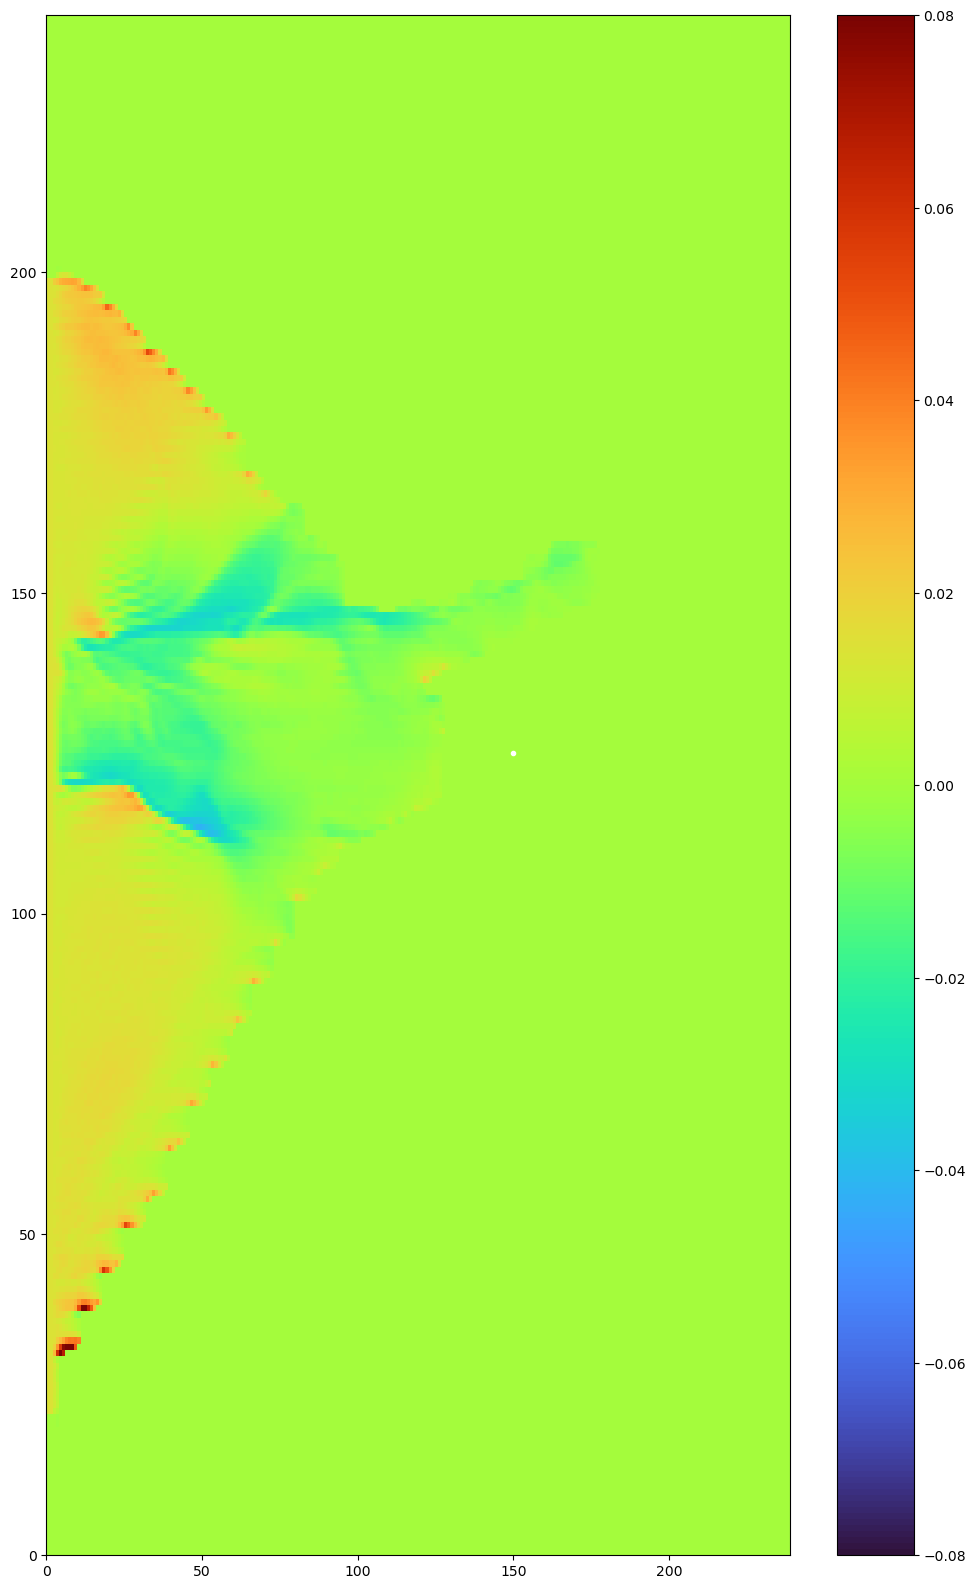

In [54]:
row = 125
col = 150
plt.figure(figsize=(12, 20))
C = plt.pcolormesh(grid[0,0,:,:-1], cmap='turbo', vmin=-0.08,vmax=0.08)
plt.plot(col,row,'w.')
plt.colorbar(C)
plt.show()

When I'm happy with the location of the point, I'll loop through all of the output files to generate a timeseries:

In [8]:
timestep_numbers = []
vel_values = []

folder = os.path.join(run_dir, 'vel_3D_mon_snap')

Nx = n_cols  # 240
Ny = n_rows  # 240
Nz = 140     # from meta file
Nf = 2       # UVEL + VVEL

expected_size = Nx * Ny * Nz * Nf * 4  # bytes

for file_name in sorted(os.listdir(folder)):
    if file_name.endswith('.data'):
        path = os.path.join(folder, file_name)

        size = os.path.getsize(path)
        print(f"{file_name}: {size} bytes")

        if size != expected_size:
            print(f"❌ ERROR: wrong file size, cannot reshape {file_name}")
            continue

        # safe read
        grid = np.fromfile(path, dtype='>f4')

        try:
            grid = grid.reshape((Nf, Nz, Ny, Nx))
        except Exception as e:
            print(f"❌ RESHAPE FAILED for {file_name}: {e}")
            continue

        timestep_numbers.append(int(file_name.split('.')[-2]))
        vel_values.append(grid[0, 0, row, col])  # UVEL at surface


vel_3D_mon_snap.0000000900.data: 64512000 bytes
vel_3D_mon_snap.0000002700.data: 64512000 bytes
vel_3D_mon_snap.0000004500.data: 64512000 bytes
vel_3D_mon_snap.0000006300.data: 64512000 bytes
vel_3D_mon_snap.0000008100.data: 64512000 bytes
vel_3D_mon_snap.0000009900.data: 64512000 bytes
vel_3D_mon_snap.0000011700.data: 64512000 bytes
vel_3D_mon_snap.0000013500.data: 64512000 bytes
vel_3D_mon_snap.0000015300.data: 64512000 bytes
vel_3D_mon_snap.0000017100.data: 64512000 bytes
vel_3D_mon_snap.0000018900.data: 64512000 bytes
vel_3D_mon_snap.0000020700.data: 64512000 bytes
vel_3D_mon_snap.0000022500.data: 64512000 bytes
vel_3D_mon_snap.0000024300.data: 64512000 bytes
vel_3D_mon_snap.0000027900.data: 64512000 bytes
vel_3D_mon_snap.0000029700.data: 64512000 bytes
vel_3D_mon_snap.0000031500.data: 64512000 bytes
vel_3D_mon_snap.0000033300.data: 64512000 bytes
vel_3D_mon_snap.0000035100.data: 64512000 bytes
vel_3D_mon_snap.0000036900.data: 64512000 bytes
vel_3D_mon_snap.0000038700.data: 6451200

In [35]:
timestep_numbers = []
vel_values = []
for file_name in sorted(os.listdir(os.path.join(run_dir,'vel_3D_mon_snap'))):
    if file_name[-4:]=='data':
        # get the timestep number
        timestep_numbers.append(int(file_name.split('.')[-2]))

        grid = np.fromfile(os.path.join(run_dir,'vel_3D_mon_snap',
                                file_name), '>f4')
        grid = grid.reshape((2,140,n_rows,n_cols))
        vel_values.append(grid[0,0,row,col])

        U = grid[0]  # UVEL
        V = grid[1] #VVEL

Finally, I'll plot the timeseries:

## Make a movie
The timeseries looks pretty good - let's take a look at how our model is evolving through time by making a movie. First, let's make and test a function to make the panels for our movie

In [41]:
plot_dir = '/Users/masonjones/Desktop/MS274/model/run1/plots'

In [56]:
def plot_panel(run_dir, plot_dir, file_name):

    # read in the data
    grid = np.fromfile(os.path.join(run_dir,'vel_3D_mon_snap',
                                file_name), '>f4')
    grid = grid.reshape((2,140,n_rows,n_cols))
    vel_values.append(grid[0,0,row,col])
    
    U = grid[0]  # UVEL
    V = grid[1] #VVEL
    timestep_number = int(file_name.split('.')[-2])

    # make a figure 
    fig = plt.figure(figsize=(12,20))
    gs1 = GridSpec(11, 10, left=0.1, right=0.98, bottom=0.06, top=0.95, hspace=0.05)

    # plot the temperature
    ax1 = fig.add_subplot(gs1[:-2, :])
    C = ax1.pcolormesh(XC[:,:-1], YC[:,:-1], grid[0,0,:,:-1], cmap='turbo', vmin=-0.05, vmax=0.08)
    plt.colorbar(C, label='Velocity (m/s)')

    # plot the land in grey
    #land = (grid[0,:,:-1]==0).astype(int)
    #print(np.min(land), np.max(land))
    #land = np.ma.masked_where(land, land==0)
    #print(land)
    #ax1.pcolormesh(XC[:,:-1], YC[:,:-1], land, cmap='Greys')#, vmin=-1, vmax=1)
    
    # format the axes
    plt.title('CA Surface Currents')
    plt.ylabel('Latitude')
    plt.xlabel('Longitude')

    max_timestep_number = int(366*24*60*60/3)
    ax2 = fig.add_subplot(gs1[-1, :-2])
    rect = Rectangle((0,0),timestep_number, 1, facecolor='grey', edgecolor='k')
    ax2.add_patch(rect)
    ax2.set_xlim([0, max_timestep_number])
    ax2.set_ylim([0, 1])
    ax2.set_xticks([0,max_timestep_number])
    ax2.set_xticklabels([2000,2001])
    ax2.set_yticklabels([])
    ax2.set_xlabel('Time')
    
    output_file = os.path.join(plot_dir,'panels',file_name[:-5]+'.png')
    plt.savefig(output_file, facecolor='white')
    plt.close(fig)


# test the function
#plot_panel(run_dir, plot_dir, 'TS_surf_daily_mean.0000016992.data')
#plot_panel(run_dir, plot_dir, 'TS_surf_daily_mean.0000068256.data')

When we're happy with the plotting function, we can use it to make the panels:

In [57]:
for file_name in sorted(os.listdir(os.path.join(run_dir,'vel_3D_mon_snap'))):
    if file_name[-4:]=='data':
        plot_panel(run_dir, plot_dir, file_name)

And then stitch everything together into a movie:

In [58]:
panel_list = []
for file_name in sorted(os.listdir(os.path.join(plot_dir,'panels'))):
    if file_name[-4:]=='.png':
        panel_list.append(os.path.join(plot_dir,'panels',file_name))

In [59]:
# set the frames per second
fps=8

# use the ImageSequenceClip module to set up the clip
clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(panel_list, fps=fps)

# write the video to a file
clip.write_videofile(os.path.join(plot_dir,'CA Sea Surface Velocity4.mp4'))

MoviePy - Building video /Users/masonjones/Desktop/MS274/model/run1/plots/CA Sea Surface Velocity4.mp4.
MoviePy - Writing video /Users/masonjones/Desktop/MS274/model/run1/plots/CA Sea Surface Velocity4.mp4



MoviePy - Done !
MoviePy - video ready /Users/masonjones/Desktop/MS274/model/run1/plots/CA Sea Surface Velocity4.mp4


This is just a first analysis with my first model run. Next, I will work to run my next model experiment and analyze the comparison.